# MNIST classifier

This notebook illustrates the use of a `BaseModel` sub-class (`MNISTClassifier`) to classify `MNIST` data (28x28 images representing digits). All the projects are based on the `BaseModel` abstraction, allowing to group in the same class : the data processing pipeline, the training / processing hyper-parameters (configuration), and the `keras.Model` architecture. 

1. The first step is to initialize the model by providing all the model-specific configurations (in this case, the `input_size` and the `labels`)
    - The constructor initializes the directories to save the model configuration + the architecture weights
    - The `build` function is then called to instantiate the `keras.Model` instance
    - The configuration + architecture weights are saved in the model directory (`pretrained_models/{name}`)
2. Once the model has been instanciated, it can be restored via the `get_pretrained` function, or by re-creating it with the same name.
    - If a directory with the model name already exists, it will be restored based on the configuration files to restore configuration + deserialize the `keras.Model` architecture + load the expected checkpoint
3. The second step is to `compile` the model : it means to define the optimizer, loss and metrics used during training
    - In general, `BaseModel` sub-classes redefines this method, or defines the `_default_loss` attribute so that it can be compiled without providing any additional information. Nonetheless, it is possible to pass custom `{loss / metrics / optimizer}_config` as arguments
4. The final step before training the model is to load the dataset ! For this purpose, the `get_dataset` method allows to automatically load the expected datase based on its name (and possible additional configurations)
5. (Optional) A good practice is to check the processing pipeline to ensure that everything is working as expected. For this purpose, check the last cells of this notebook, that allow proper visualization of the processing impact on data
6. Let's train the model ! :smile: The `fit` method of the `BaseModel` class handles the creation of a `tf.data` pipeline that properly processes the given dataset before passing it to the `keras.Model.fit` method !
    - In addition, the `fit` method adds custom callbacks to track the training metrics / information to enable better understanding / reproductibility
7. Once the training is finished, the model is automatically saved, and you can use it for prediction / evaluation !

*This repository is **not** an official classification project, meaning that it is not fully integrated with the dedicated interfaces, and thus many features are not available. It is an example on how to build, traing, restore and predict with the `BaseModel` class*

## Imports + model initialization

In [2]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd

from keras import tree

from models import MNISTClassifier, get_pretrained
from utils import set_display_options, plot, plot_multiple, plot_confusion_matrix
from utils.keras_utils import show_version, ops
from utils.datasets import get_dataset, prepare_dataset, test_dataset_time

set_display_options()

model_name = 'mnist_classifier'
show_version()

Keras version : 3.4.1 - backend (tensorflow) : 2.16.1


In [2]:
input_shape = (28, 28, 1)
model = MNISTClassifier(input_size = input_shape, labels = list(range(10)), nom = model_name)

print(model)

Initializing model with kwargs : {'architecture': 'simple_cnn', 'input_shape': (28, 28, 1), 'output_shape': 10, 'n_conv': 2, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'pooling': 'max', 'dense_as_final': True, 'n_dense': 1, 'dense_size': 64, 'final_activation': 'softmax', 'final_name': 'classification_layer', 'name': 'cnn_classifier'}
Set `use_mask = False` by default as the masking operation is not supported. To remove this message or change the behavior, explicitely pass `use_mask = ...`
Save `model` to pretrained_models/mnist_classifier/saving/ckpt-0000.keras
MNISTClassifier `mnist_classifier` initialized successfully !

========== mnist_classifier ==========
Model instance `model`
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 16
- Number of parameters 	: 28048
- Model not compiled yet

Already trained on 0 epochs (0 steps)

- Labels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



In [3]:
model.summary()

Model: "cnn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_1 (BatchNormalization)     │ (None, 28, 28, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation               │ (None, 28, 28, 16)     │             0 │
│ (CustomActivation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_2 (BatchNormalization)     │ (None, 14, 14, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_1             │ (None, 14, 14, 16)     │             0 │
│ (CustomActivation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_2             │ (None, 32)             │             0 │
│ (CustomActivation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_layer (Dense)    │ (None, 10)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_3             │ (None, 10)             │             0 │
│ (CustomActivation)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,048 (109.56 KB)

 Trainable params: 27,984 (109.31 KB)

 Non-trainable params: 64 (256.00 B)

## Model instanciation + dataset loading

Once initialized, the model can be restored just by passing its name as argument. Furthermore, all models are `Singleton`, meaning that if your model has already been restored, it will return the existing instance (and will not restore it) (*unless explicitely required via the `reload = True` argument*) !

In [3]:
model = get_pretrained(model_name) # Equivalent to `MNISTClassifier(name = model_name)`

model.compile()

print(model)

The model is already compiled. To verwrite the current compilation, pass `overwrite = True` as `compile` argument

========== mnist_classifier ==========
Model instance `model`
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 16
- Number of parameters 	: 28048

- Optimizer 	: {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
- Loss 	: crossentropy

Already trained on 9 epochs (8442 steps)

- Labels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



In [4]:
ds = get_dataset('mnist')

if isinstance(ds, dict):
    train, valid = ds['train'], ds['test']
    print(train)
    print(valid)
else:
    train, valid = ds
    print('train : {} - valid : {}'.format(
        tree.map_structure(ops.shape, train), tree.map_structure(ops.shape, valid)
    ))


train : ((60000, 28, 28), (60000,)) - valid : ((10000, 28, 28), (10000,))


## Training + history analysis

Note that the training has finished after 9 epochs, while 15 were expected. This is due to the `EarlyStopping` callback, allowing to stop the training when a convergence criterion is reached. In this case, no improvement of the `val_loss` during 3 (`patience`) epochs.

In [4]:
model.fit(
    train,
    validation_data = valid,
    epochs     = 15,
    batch_size = 64,
    
    additional_infos = {'dataset' : 'mnist'},
    
    add_early_stopping = True,
    patience = 3
)

Training config :
HParams :
- augment_prct	: 0.25
- x	: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
- epochs	: 15
- callbacks	: [<History epochs=0 steps=0>, <keras.src.callbacks.terminate_on_nan.TerminateOnNaN object at 0x7f09501152e0>, <keras.src.callbacks.early_stopping.EarlyStopping object at 0x7f0950115580>, <custom_train_objects.callbacks.checkpoint_callback.CheckpointCallback object at 0x7f0950115be0>]
- initial_epoch	: 0
- validation_data	: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Epoch 1/15


I0000 00:00:1717145852.402858    2186 service.cc:145] XLA service 0x7f083400cb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717145852.402882    2186 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-05-31 10:57:32.431022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-31 10:57:32.541194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


195/938 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.3805 - loss: 2.0849

I0000 00:00:1717145854.693092    2186 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6079 - loss: 1.8633 - val_accuracy: 0.8655 - val_loss: 1.5973
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.8440 - loss: 1.6210 - val_accuracy: 0.9721 - val_loss: 1.4919
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9363 - loss: 1.5289 - val_accuracy: 0.9764 - val_loss: 1.4849
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.9466 - loss: 1.5170 - val_accuracy: 0.9784 - val_loss: 1.4829
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9511 - loss: 1.5113 - val_accuracy: 0.9811 - val_loss: 1.4804
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9533 - loss: 1.5091 - val_accuracy: 0.9829 - val_loss: 1.4786
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9585 - loss: 1.5038 - val_accuracy: 0.9823 - val_loss: 1.4792
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.9618 - loss: 1.5006 - val_accuracy: 0.983

<History epochs=9 steps=8442>

===== History =====
       loss  sparse_categorical_accuracy  val_loss  val_sparse_categorical_accuracy
0  1.629513                     0.841867  1.494346                           0.9693
1  1.516840                     0.948117  1.486331                           0.9758
2  1.507093                     0.956450  1.480888                           0.9810
3  1.502189                     0.960467  1.481126                           0.9802
4  1.498205                     0.964417  1.478707                           0.9824


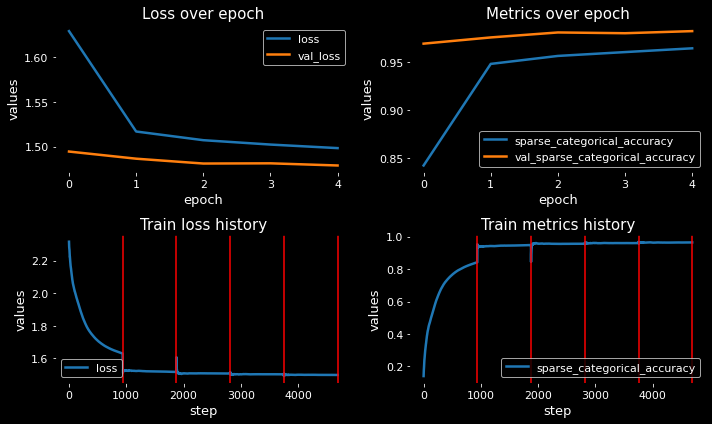

In [7]:
print(model.history)
model.plot_history()

In [6]:
print("Training config :")
print(pd.DataFrame(model.training_logs))
print("\nTraining parameters :")
print(pd.DataFrame(model.training_config))
print("\nTraining informations :")
print(pd.DataFrame(model.training_infos))


Training config :
          start           end       time  interrupted  start_epoch  final_epoch
0  1.717146e+09  1.717146e+09  13.924921        False            0            9

Training parameters :
   batch_size  add_early_stopping  patience  augment_prct  epochs  initial_epoch
0          64                True         3          0.25      15              0

Training informations :
          start           end       time  interrupted  start_epoch  final_epoch                     dataset  \
0  1.717146e+09  1.717146e+09  13.924921        False            0            9  {'train': {}, 'valid': {}}   

       additional_infos  
0  {'dataset': 'mnist'}  


## Prediction

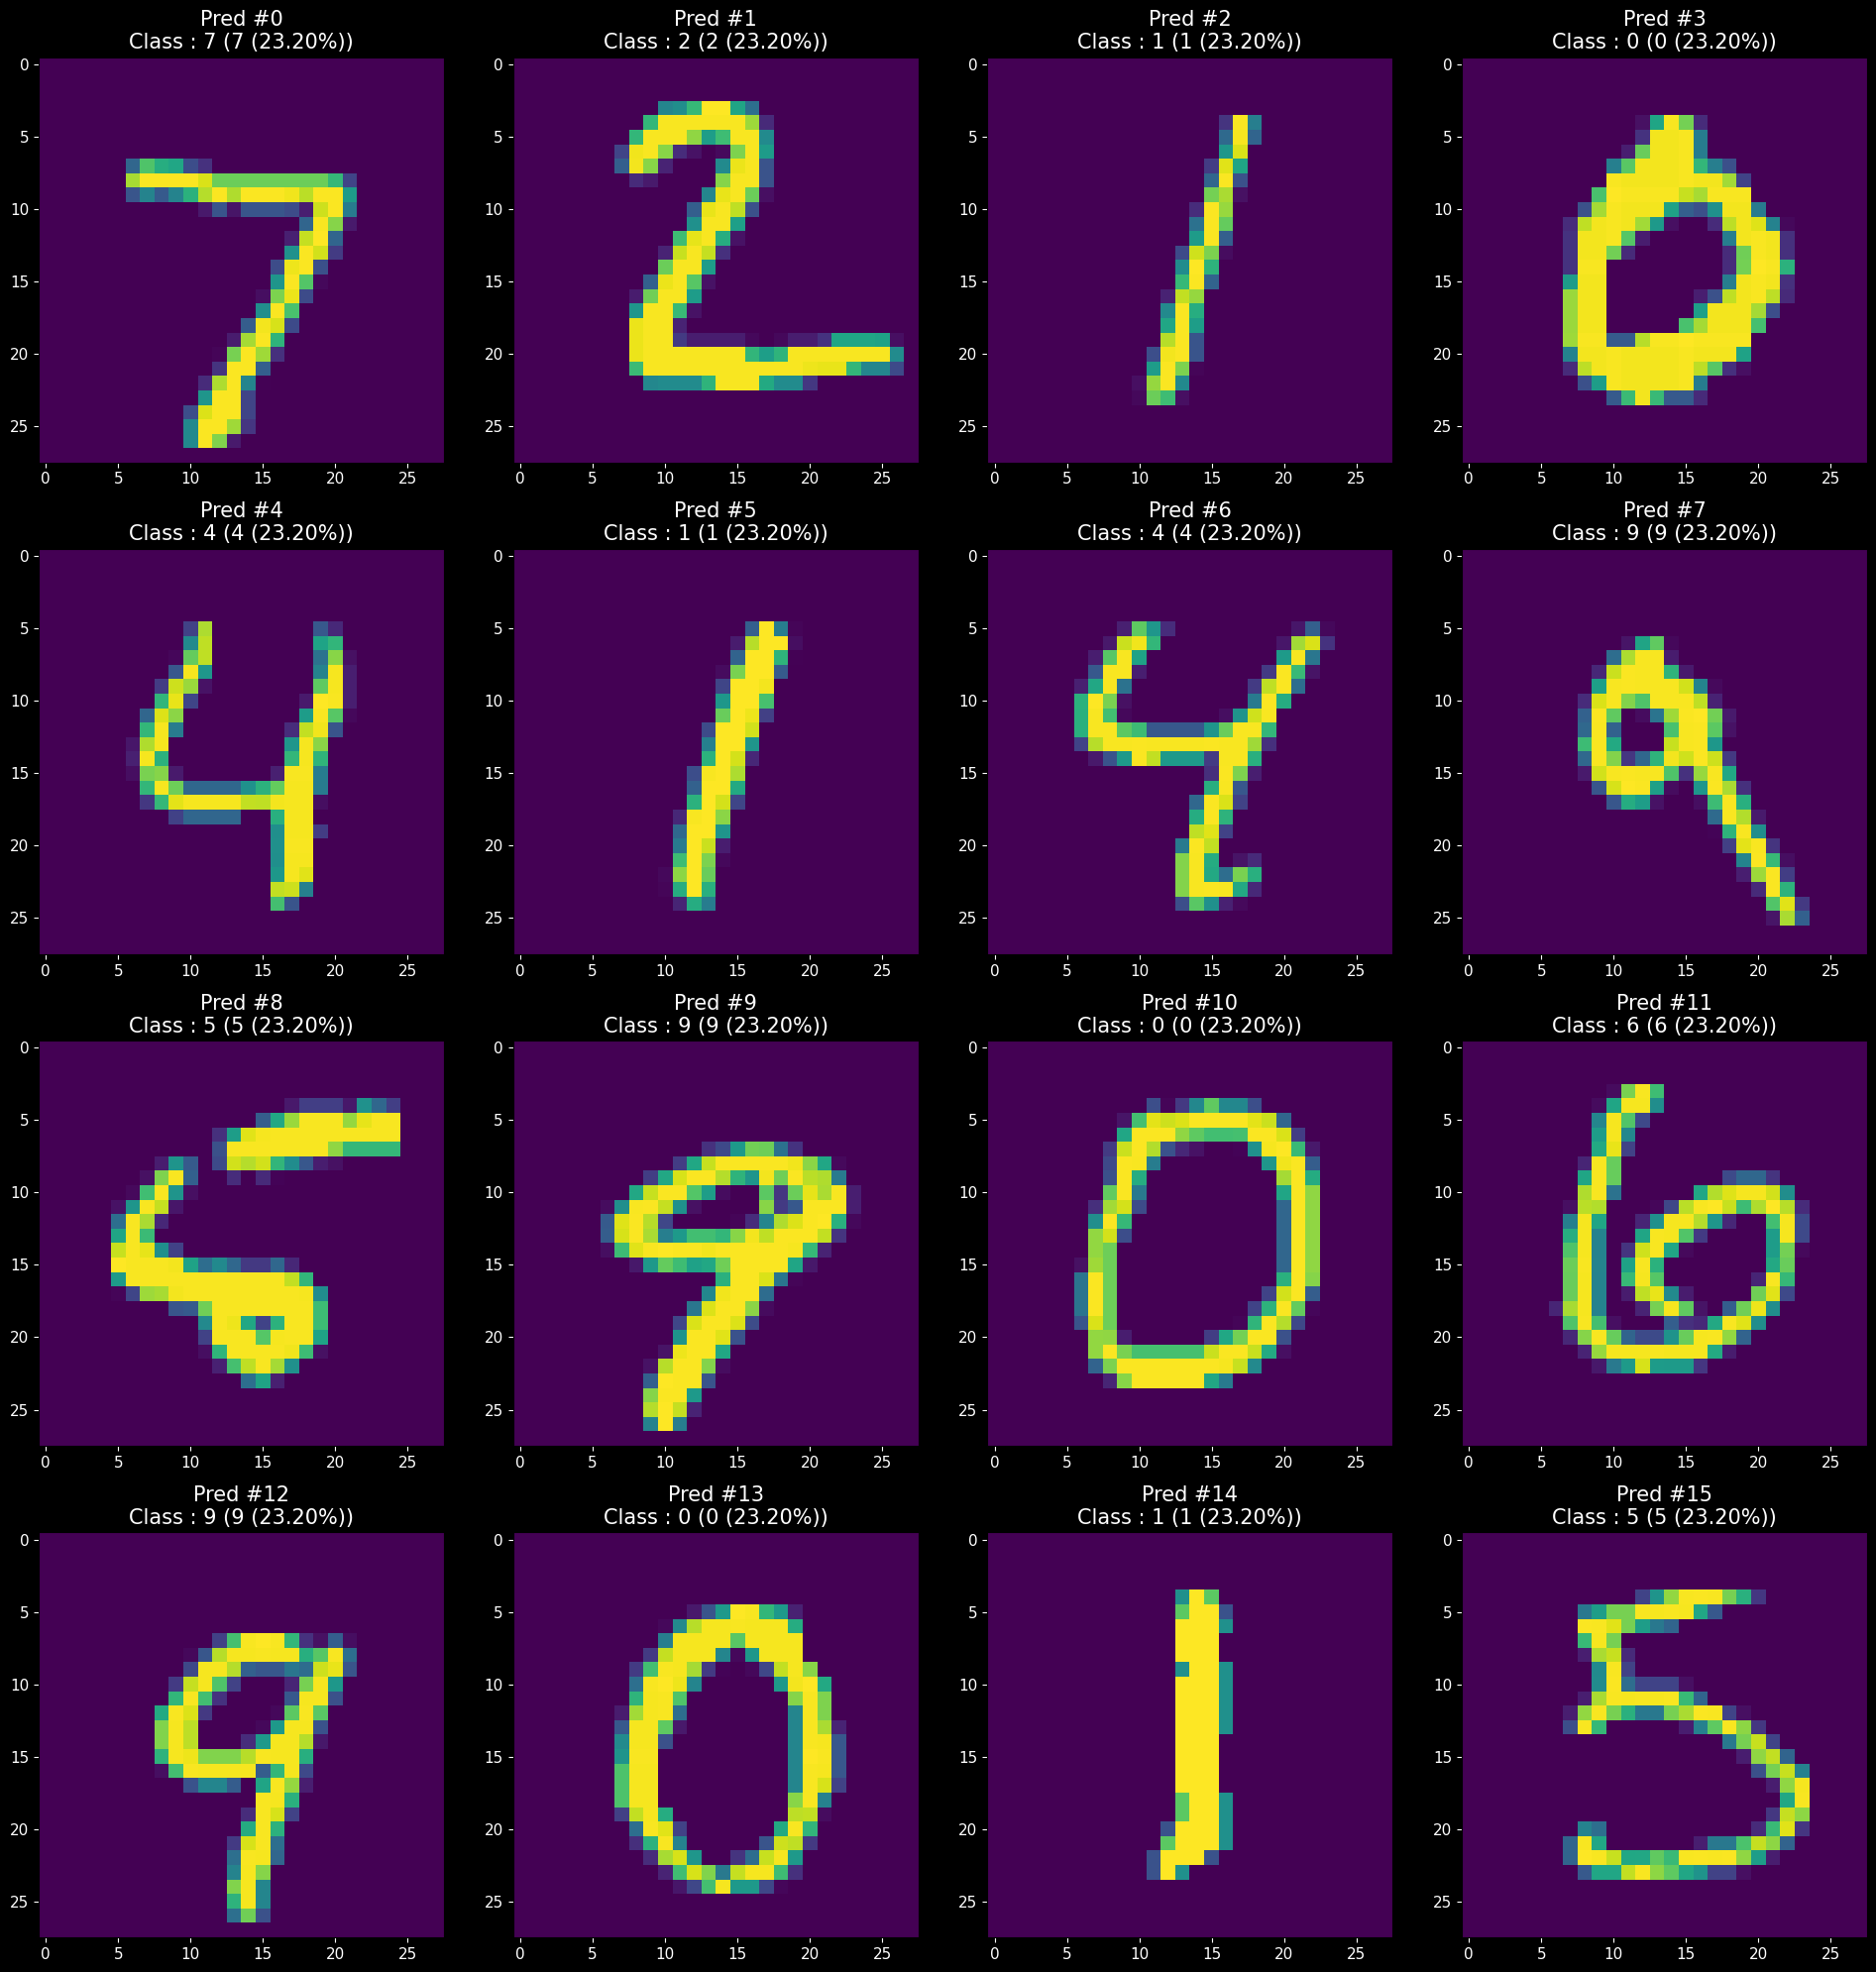

In [7]:
predictions = {}
for i, data in enumerate(zip(* valid)):
    if i >= 16: break
    image, label = model.prepare_data(* data)
    
    pred, score, probs = model.predict([image])[0]
    predictions['Pred #{}\nClass : {} ({} ({:.2f}%))'.format(i, label, pred, score * 100)] = image

plot_multiple(** predictions, ncols = 4, plot_type = 'imshow')

## Confusion matrix

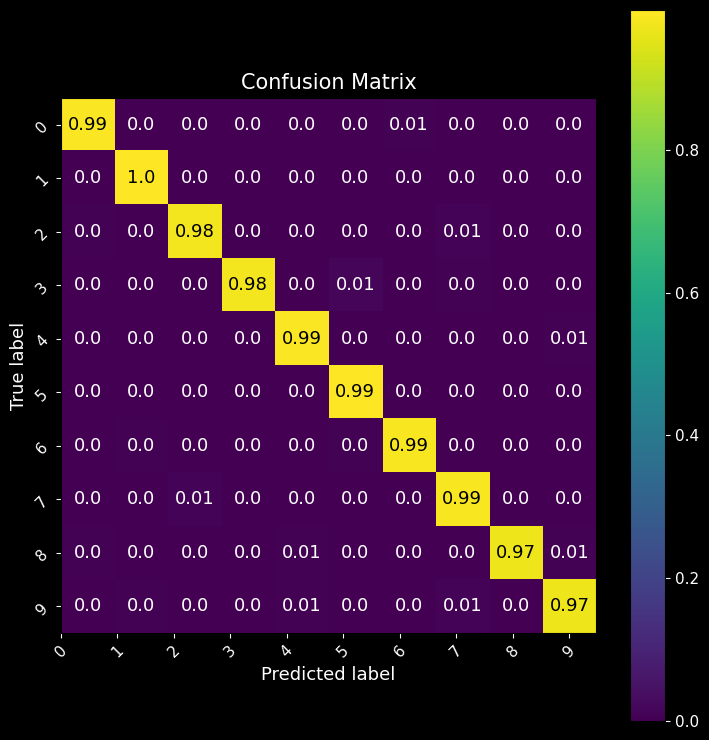

In [8]:
images, labels = [], []
for i, data in enumerate(zip(* valid)):
    image, label = data #model.prepare_data(* data)
    images.append(image)
    labels.append(label)

pred = model.predict(images)
pred = [p[0] for p in pred] # p[1] is the confidence score

plot_confusion_matrix(true = labels, pred = pred, norm = True)

## Test processing pipeline

When it is the first time you train a model, it is recommanded to assess the correctness of the processing pipeline. The below cells illustrate how to check the data statistics (values within a batch), as well as a visual analysis of the processing result. 

- The `get_dataset_config` returns the processing functions defined by the model that have to be forwarded to the `prepare_dataset` method
- The `prepare_dataset` instanciates a `tf.data.Dataset` instance based on the given data (also supports `pd.DataFrame` as well as other dataset formats)

This analysis demonstrates the correct alignment between images and labels, as well as correct value ranges for the image pixels (i.e., between 0 and 1)

In [9]:
from loggers import set_level

set_level('debug', 'utils.datasets') # the 2nd argument tells to only set the `datasets.*` module to debug

config = model.get_dataset_config('train', batch_size = 64)

ds_train = prepare_dataset(train, ** config)
test_dataset_time(ds_train, steps = 1000)

Original dataset : <_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
- Dataset after preparation : <_ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
- Dataset is cached
- Dataset is shuffled
- Dataset after batch : <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
- Dataset is prefetched


 94%|█████████████████████████████████████████████████████████████████████████▏    | 938/1000 [00:00<00:00, 2152.81it/s]


938 batches generated in 435 ms (2154.893 batch / sec)
- Initial batch time : 382 ms
- Average batch time : 464 μs
- Batch statistics   : [
    "shape : (32, 28, 28, 1) - min : 0.000 - max : 1.000 - mean : 0.128",
    "shape : (32,) - min : 0 - max : 9"
]



{'steps': 938,
 'batch_size': 64,
 'total time': 0.4352884292602539,
 'initial batch time': 0.3825414180755615,
 'average batch time': 0.00046406015912607026}

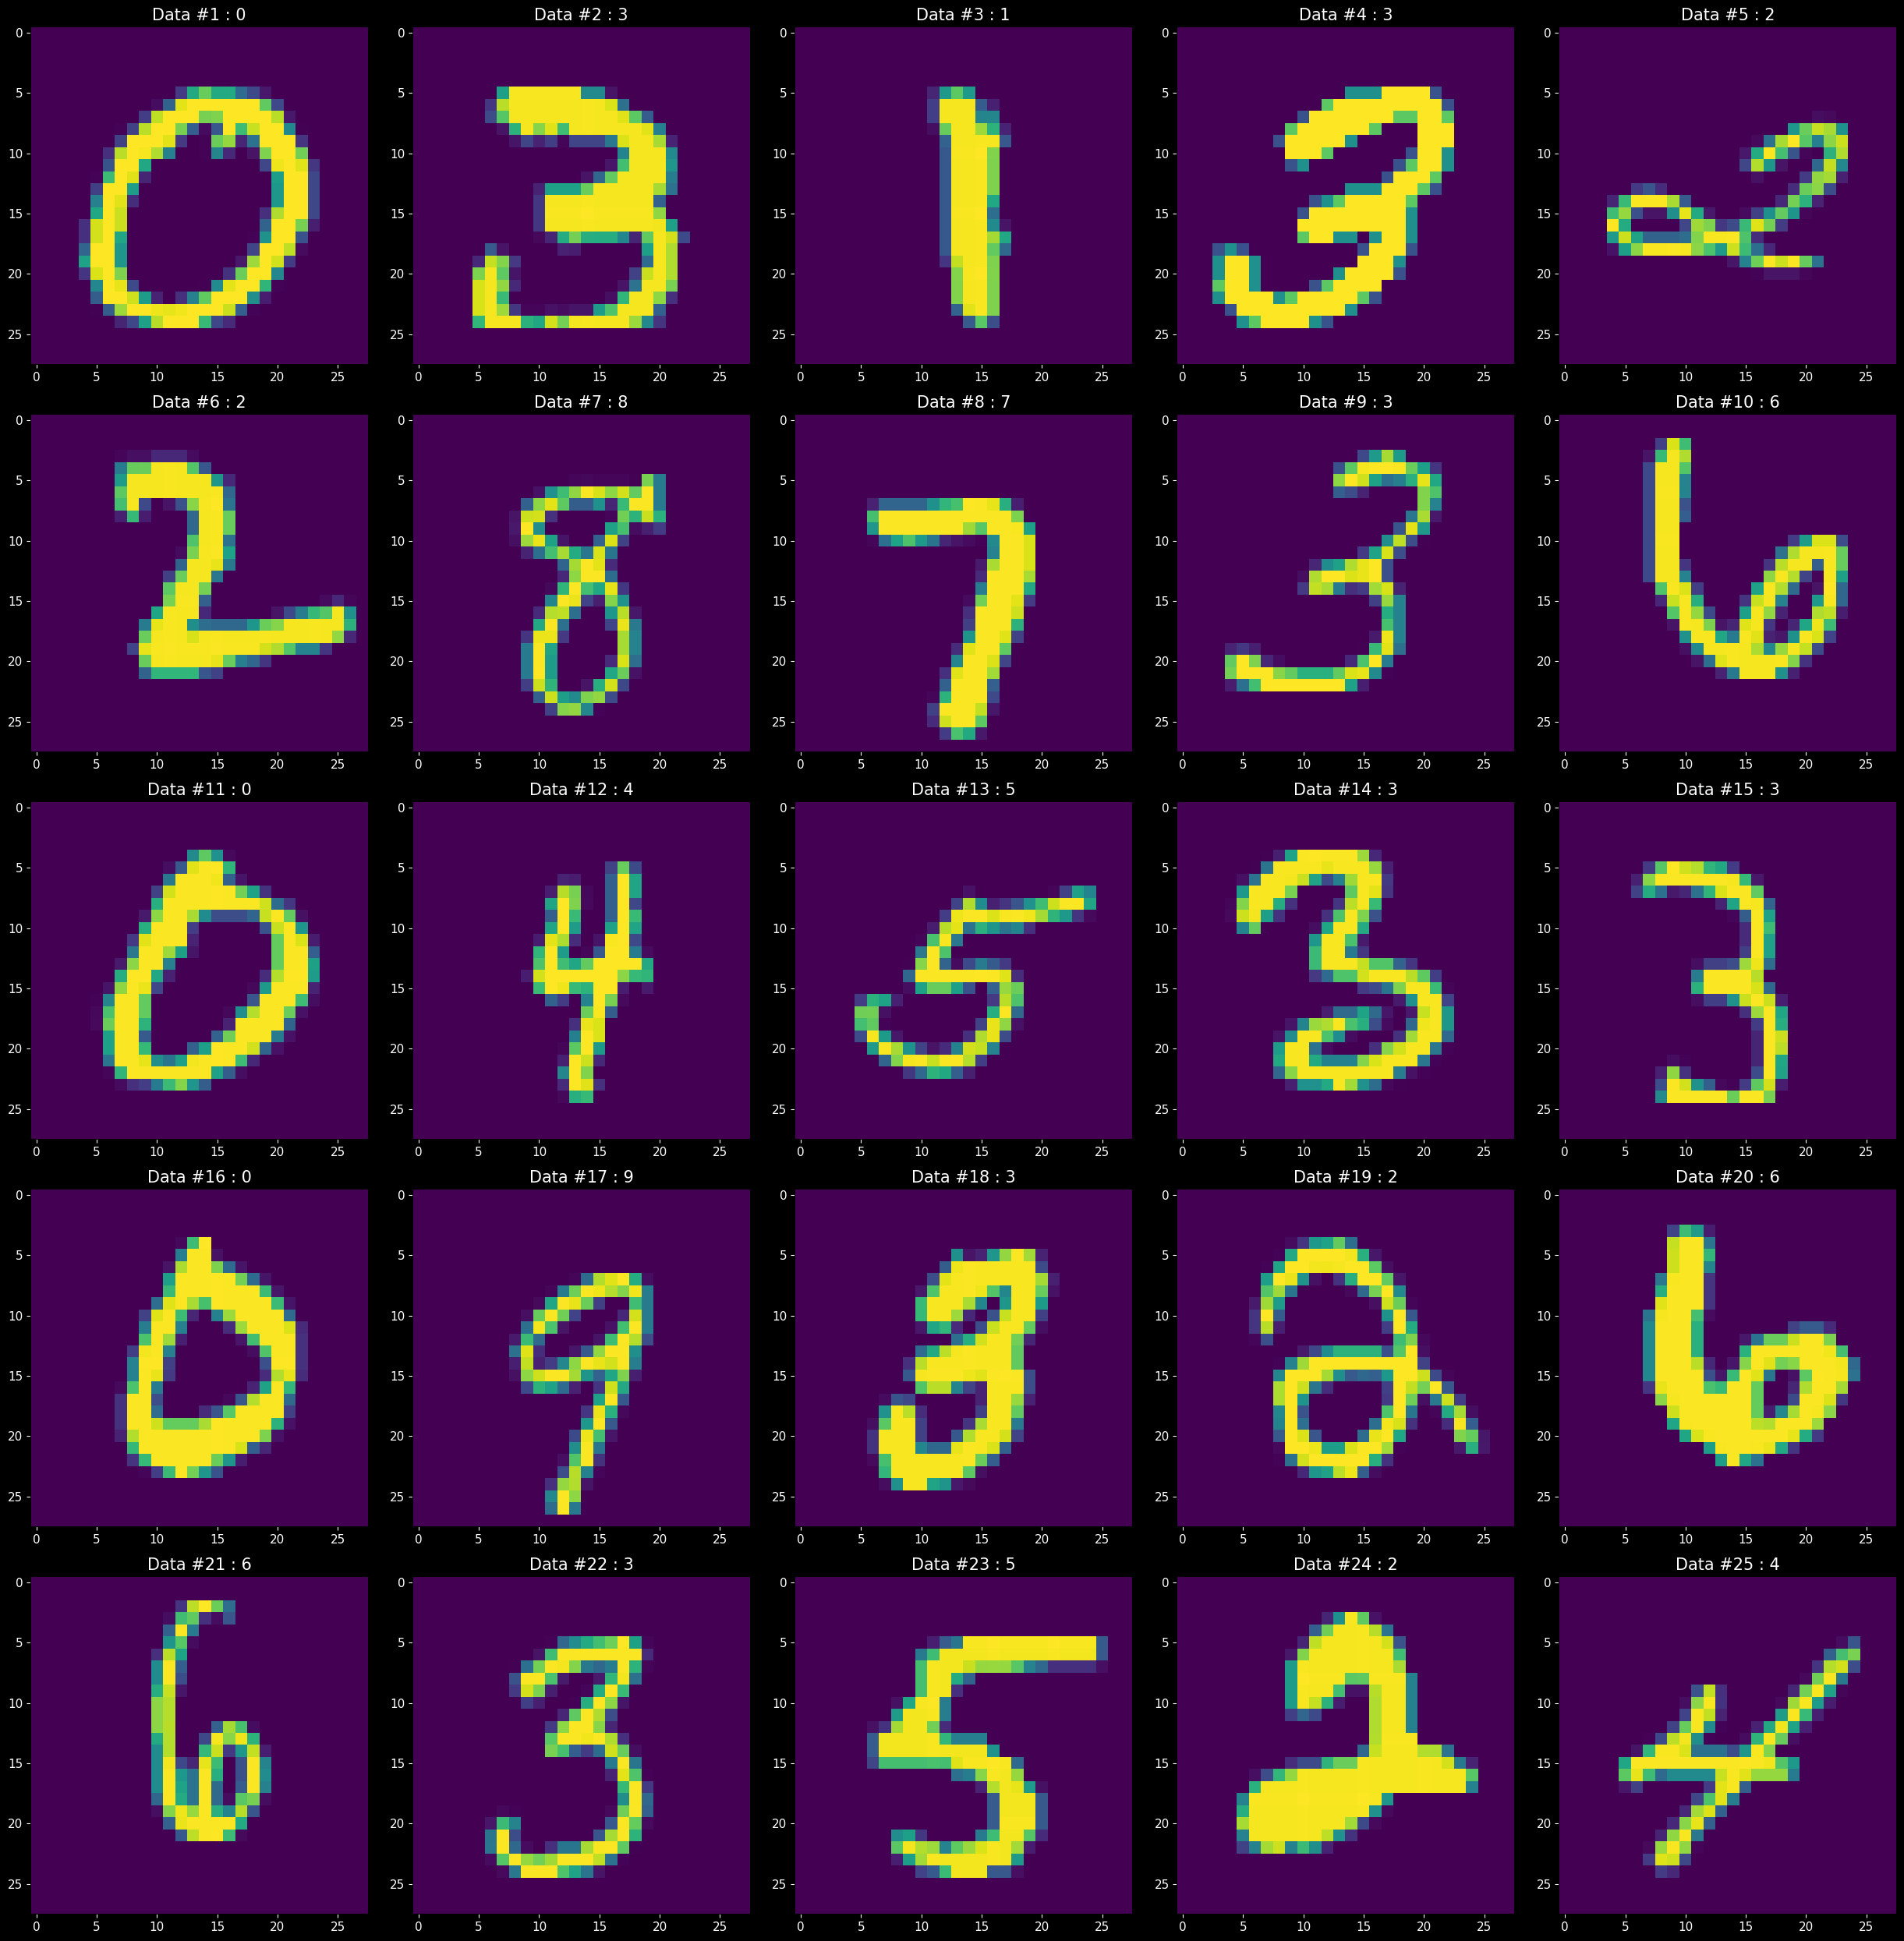

In [8]:
# Initializes the `tf.data.Dataset` instance with all defined processing functions
config = model.get_dataset_config('train', batch_size = 25)

ds_train = prepare_dataset(train, ** config)

# Get the 1st batch of data
inp, out = next(iter(ds_train))

data = {
    'Data #{} : {}'.format(i + 1, label) : img
    for i, (img, label) in enumerate(zip(inp, out))
}

plot_multiple(** data, ncols = 5, plot_type = 'imshow')